In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import missingno as msno
from wordcloud import WordCloud, STOPWORDS
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
train = pd.read_csv("data/km_train_extra_v2.csv", encoding='utf-8', sep=',')

test = pd.read_csv("data/km_test_extra_v2.csv", encoding='utf-8', sep=',')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolAreaYes,MiscValYes,YrSoldDiff,kn_8,kn_16,kn_32,kn_64,kn_128,kn_256,kn_512
0,1,60,3,0.212898,-0.205996,1,1,3,3,0,...,0,0,3,1,2,5,26,45,24,42
1,2,20,3,0.645875,-0.090876,1,1,3,3,0,...,0,0,4,5,15,18,47,54,73,281
2,3,60,3,0.299493,0.074297,1,1,0,3,0,...,0,0,3,1,2,5,26,45,24,321
3,4,70,3,0.068572,-0.095881,1,1,0,3,0,...,0,0,5,4,7,22,10,78,211,146
4,5,60,3,0.761335,0.375612,1,1,0,3,0,...,0,0,3,1,2,5,52,2,3,484


In [5]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolAreaYes,MiscValYes,YrSoldDiff,kn_8,kn_16,kn_32,kn_64,kn_128,kn_256,kn_512
0,1461,20,2,0.684849,0.363929,1,1,3,3,0,...,0,0,1,5,8,10,29,0,160,509
1,1462,20,3,0.715852,0.897861,1,1,0,3,0,...,0,1,1,5,8,10,29,0,160,397
2,1463,60,3,0.498831,0.809646,1,1,0,3,0,...,0,0,1,1,2,12,52,62,105,212
3,1464,60,3,0.622843,0.032064,1,1,0,3,0,...,0,0,1,1,2,12,52,62,105,212
4,1465,120,3,-0.462261,-0.971808,1,1,0,1,0,...,0,0,1,6,4,27,49,67,115,242


In [6]:
X = train.loc[:,train.columns != 'Id']
X = X.loc[:,X.columns != 'SalePrice']
y = train['SalePrice']

In [7]:
xgbr = XGBRegressor()

In [8]:
xgbr.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

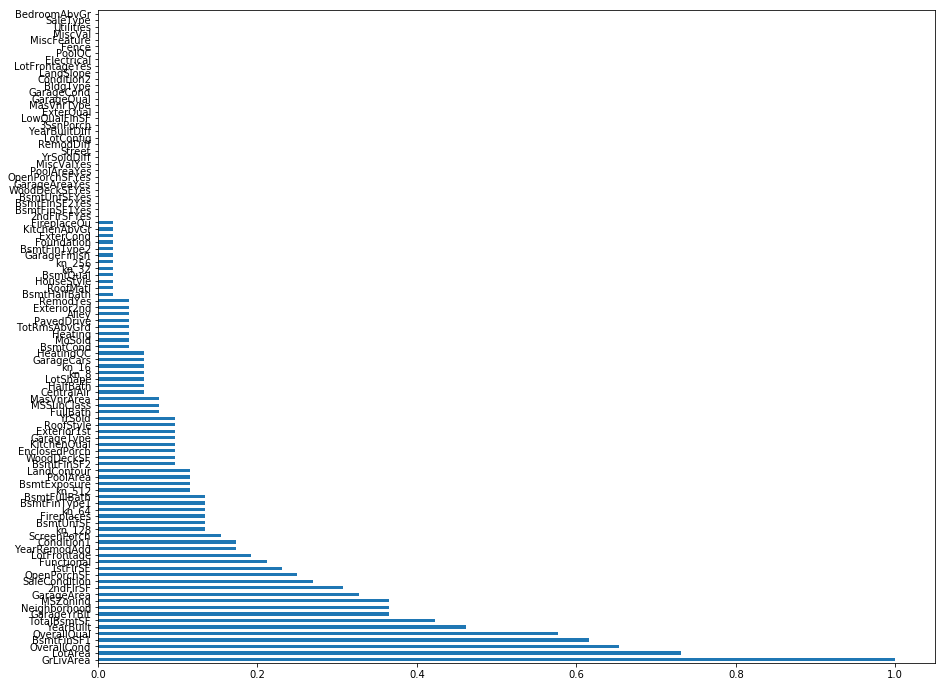

In [9]:
feat_importances_xgb = pd.Series(xgbr.feature_importances_/xgbr.feature_importances_.max(), index=X.columns)
feat_importances_xgb = feat_importances_xgb.nlargest(X.shape[1])
feat_importances_xgb.plot(kind='barh', figsize=((15,12)))

In [10]:
xgbr = XGBRegressor(max_depth=5, n_jobs=-1, eta=0.01, random_state=1992, objective='reg:linear')
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

In [11]:
def ft_sel_fun(n_init = 5, n_attemps = 3, thr = 0.0005):
    
    scores_list = list()
    best_score = 1.0
    n = 0
    features = feat_importances_xgb.index[:n_init].tolist()
    xgbr.fit(X_train[features],y_train)
    preds = xgbr.predict(X_test[features])
    rmse = mean_squared_error(y_test, preds)**(0.5)
    print('Initial RMSE:',rmse)
    best_score = rmse
    best_selection = list()
    best_selection = best_selection + features
    scores_list.append(rmse)
    for ft in feat_importances_xgb.index.tolist()[n_init:]:
        features.append(ft)
        xgbr.fit(X_train[features],y_train)
        preds = xgbr.predict(X_test[features])
        rmse = mean_squared_error(y_test, preds)**(0.5)
        print('RMSE:',rmse)
        scores_list.append(rmse)
        
        if rmse < best_score:
            print('best_score found')
            best_score = rmse
            best_selection = features
        elif abs(best_score-rmse) < thr:
            n += 1
            
        if n == n_attemps:
            print('Not improving best_score')
            break
        
    return best_selection, scores_list, best_score        

In [12]:
best_selection, scores_list, best_score = ft_sel_fun()
print(best_selection, scores_list, best_score)

Initial RMSE: 0.07160246070089804
RMSE: 0.06441320201437102
best_score found
RMSE: 0.06309393634248278
best_score found
RMSE: 0.06161999424040109
best_score found
RMSE: 0.059754293189864756
best_score found
RMSE: 0.05843054551414305
best_score found
RMSE: 0.05939391353971344
RMSE: 0.059338417474607524
RMSE: 0.059591813354230444
RMSE: 0.059667548600322584
RMSE: 0.05921323919037308
RMSE: 0.05943730194674345
RMSE: 0.06006505137020184
RMSE: 0.05971871140757305
RMSE: 0.059324692871698094
RMSE: 0.059069575179944905
RMSE: 0.05899603086537526
RMSE: 0.05920777367334909
RMSE: 0.05858928917409843
RMSE: 0.05699504448210158
best_score found
RMSE: 0.05947396347187506
RMSE: 0.058789459194376815
RMSE: 0.05791255296019097
RMSE: 0.05796142064612754
RMSE: 0.05779318492150111
RMSE: 0.05737561751410439
RMSE: 0.05741552987203082
Not improving best_score
['GrLivArea', 'LotArea', 'OverallCond', 'BsmtFinSF1', 'OverallQual', 'YearBuilt', 'TotalBsmtSF', 'GarageYrBlt', 'Neighborhood', 'MSZoning', 'GarageArea', '2

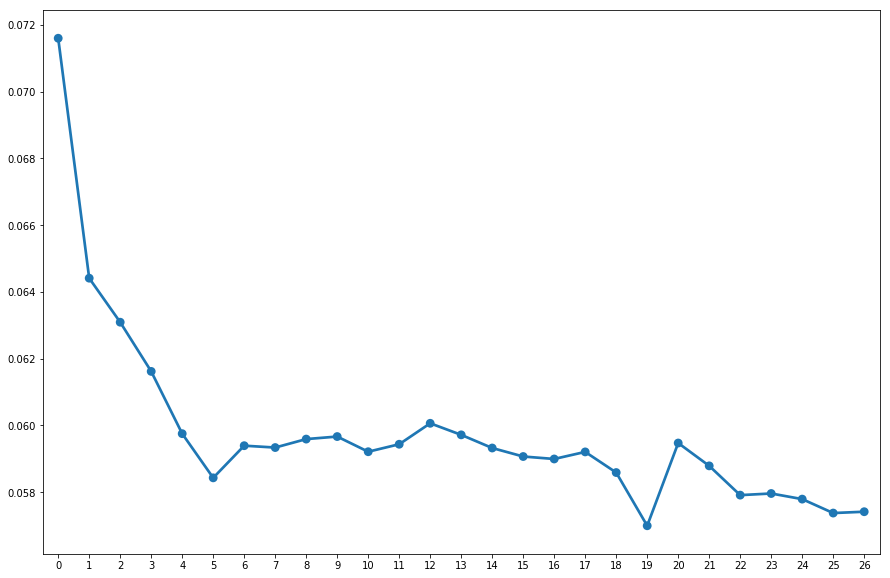

In [13]:
ig, ax = plt.subplots(figsize=(15,10))
sns.pointplot(ax=ax, x = list(range(len(scores_list))),y = scores_list)

In [14]:
xgbr.fit(X_train[best_selection],y_train)
preds = xgbr.predict(X_test[best_selection])
rmse = mean_squared_error(y_test, preds)**(0.5)
print('RMSE:',rmse)

RMSE: 0.05741552987203082


In [15]:
len(best_selection)

31

In [16]:
best_selection.append('Id')

In [17]:
test_sel = test.loc[:,best_selection]

In [18]:
test_sel.columns

Index(['GrLivArea', 'LotArea', 'OverallCond', 'BsmtFinSF1', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'GarageYrBlt', 'Neighborhood', 'MSZoning',
       'GarageArea', '2ndFlrSF', 'SaleCondition', 'OpenPorchSF', '1stFlrSF',
       'Functional', 'LotFrontage', 'YearRemodAdd', 'Condition1',
       'ScreenPorch', 'kn_128', 'BsmtUnfSF', 'Fireplaces', 'kn_64',
       'BsmtFinType1', 'BsmtFullBath', 'kn_512', 'BsmtExposure', 'PoolArea',
       'LandContour', 'BsmtFinSF2', 'Id'],
      dtype='object')

In [19]:
test_sel.head()

,GrLivArea,LotArea,OverallCond,BsmtFinSF1,OverallQual,YearBuilt,TotalBsmtSF,GarageYrBlt,Neighborhood,MSZoning,...,Fireplaces,kn_64,BsmtFinType1,BsmtFullBath,kn_512,BsmtExposure,PoolArea,LandContour,BsmtFinSF2,Id
0,-1.215588,0.363929,6,0.063428,5,1961,-0.370716,1961.0,12,2,...,0,29,5,0.0,509,3,-0.057227,3,0.517537,1461
1,-0.323539,0.897861,6,1.063511,6,1958,0.639230,1958.0,12,3,...,0,29,0,0.0,397,3,-0.057227,3,-0.297689,1462
2,0.294508,0.809646,5,0.773377,5,1997,-0.266784,1997.0,8,3,...,1,52,2,0.0,212,3,-0.057227,3,-0.297689,1463
3,0.243004,0.032064,6,0.357958,6,1998,-0.271303,1998.0,8,3,...,1,52,2,0.0,212,3,-0.057227,3,-0.297689,1464
4,-0.424487,-0.971808,5,-0.387160,8,1992,0.528520,1992.0,22,3,...,0,49,0,0.0,242,3,-0.057227,1,-0.297689,1465


In [20]:
# best_selection.append('SalePrice')

In [21]:
best_selection = best_selection+['SalePrice']

In [23]:
train_sel = train[best_selection]

In [24]:
train_sel.columns

Index(['GrLivArea', 'LotArea', 'OverallCond', 'BsmtFinSF1', 'OverallQual',
       'YearBuilt', 'TotalBsmtSF', 'GarageYrBlt', 'Neighborhood', 'MSZoning',
       'GarageArea', '2ndFlrSF', 'SaleCondition', 'OpenPorchSF', '1stFlrSF',
       'Functional', 'LotFrontage', 'YearRemodAdd', 'Condition1',
       'ScreenPorch', 'kn_128', 'BsmtUnfSF', 'Fireplaces', 'kn_64',
       'BsmtFinType1', 'BsmtFullBath', 'kn_512', 'BsmtExposure', 'PoolArea',
       'LandContour', 'BsmtFinSF2', 'Id', 'SalePrice'],
      dtype='object')

In [26]:
train_sel.head()

,GrLivArea,LotArea,OverallCond,BsmtFinSF1,OverallQual,YearBuilt,TotalBsmtSF,GarageYrBlt,Neighborhood,MSZoning,...,kn_64,BsmtFinType1,BsmtFullBath,kn_512,BsmtExposure,PoolArea,LandContour,BsmtFinSF2,Id,SalePrice
0,0.372562,-0.205996,5,0.579345,7,2003,-0.457576,2003.0,5,3,...,26,2,1,42,3,-0.068905,3,-0.289621,1,5.319106
1,-0.479767,-0.090876,8,1.176868,6,1976,0.469865,1976.0,24,3,...,47,0,0,281,1,-0.068905,3,-0.289621,2,5.258877
2,0.517154,0.074297,5,0.096054,7,2001,-0.311378,2001.0,5,3,...,26,2,1,321,2,-0.068905,3,-0.289621,3,5.349278
3,0.385880,-0.095881,5,-0.497076,7,1915,-0.686010,1998.0,6,3,...,10,0,1,146,3,-0.068905,3,-0.289621,4,5.146128
4,1.300993,0.375612,5,0.467309,8,2000,0.202598,2000.0,15,3,...,52,2,1,484,0,-0.068905,3,-0.289621,5,5.397940


In [185]:
train.shape, test.shape

((1451, 34), (1459, 32))

In [27]:
train_sel.to_csv('data/train_ft_sel_31_v2.csv', sep = ',', index = False)

test_sel.to_csv('data/test_ft_sel_31_v2.csv', sep = ',', index = False)